In [74]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import math
import yfinance as yf
import matplotlib.pyplot as plt

yf.pdr_override()

def create_dataset(dataset, look_back=30):
    x, y = [], []
    for i in range(look_back, len(dataset)):
        x.append(dataset[i-look_back:i, 0])
        y.append(dataset[i, 0])
    return np.array(x), np.array(y)

# stock ticker list
# , "PEP","MCD","AMZN","MSFT","GOOG","META","PG","KO","NKE"
tickers = ["AAPL","PEP","MCD","AMZN","MSFT","GOOG","META","PG","KO","NKE"]
start_date = "2015-01-01"
end_date = "2023-12-12"

def get_stock_data(tickers):
    dfs = []
    for ticker in tickers:
        df = web.get_data_yahoo(ticker, start=start_date, end=end_date)
        dfs.append(df)
    return dfs

dfs = get_stock_data(tickers)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [75]:
# add new residual column
for df in dfs:
    df['Residual'] = (df['Close'] - df['Open']) / df['Open']
# define 


In [59]:
def create_dataset(dataset, look_back=30):
    x, y = [], []
    for i in range(look_back, len(dataset)):
        x.append(dataset[i-look_back:i, 0])
        y.append(dataset[i, 0])
    return np.array(x), np.array(y)

# stock ticker list
tickers = ["AAPL", "PEP","MCD","AMZN","MSFT","GOOG","META","PG","KO","NKE"]
start_date = "2015-01-01"
end_date = "2023-12-12"

def get_stock_data(tickers):
    dfs = []
    for ticker in tickers:
        df = web.get_data_yahoo(ticker, start=start_date, end=end_date)
        dfs.append(df)

get_stock_data(tickers)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [56]:
features_list = [['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close','Residual'],['Residual'],['Open','Residual'], ['Residual','Open','High','Low']]
model_list = ['LSTM','GRU','RNN']
window_sizes = [15,30]


In [57]:
import itertools
import pickle
def creat_model(model_name, windown_size, feature_len):
    model = Sequential()
    if model_name == 'LSTM':
        model.add(LSTM(128, input_shape=(windown_size, feature_len),return_sequences=True))
        model.add(LSTM(128, return_sequences=False))
    elif model_name == 'GRU':
        model.add(GRU(128, input_shape=(windown_size, feature_len),return_sequences=True))
        model.add(GRU(128, return_sequences=False))
    elif model_name == 'RNN':
        model.add(SimpleRNN(128, input_shape=(windown_size, feature_len), return_sequences=True))
        model.add(SimpleRNN(128, return_sequences=False))
    else:
        print('Model name is not correct')
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def create_dataset(dataset, window_size, target_column_index):
    data_x, data_y = [], []
    for i in range(window_size, len(dataset) - 1):  # Adjusted range to avoid going out of bounds
        data_x.append(dataset[i - window_size:i, :])
        data_y.append(dataset[i + 1, target_column_index])  # Target is the next time step
    return np.array(data_x), np.array(data_y)



def pre_processing(df, features, window_size, target_column):
    # Ensure the target column is in the features list
    if target_column not in features:
        raise ValueError(f"Target column {target_column} is not in the features list")

    # Convert DataFrame to numpy array
    dataset = df[features].values.astype('float32')

    # Normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # Get the index of the target column
    target_column_index = features.index(target_column)

    # Split into train and test sets
    train_size = int(len(dataset) * 0.8)
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

    # Create datasets for training and testing
    train_x, train_y = create_dataset(train, window_size, target_column_index)
    test_x, test_y = create_dataset(test, window_size, target_column_index)

    return train_x, train_y, test_x, test_y, scaler

def train_model(features_list, model_list, window_sizes,dfs):
    combinations = list(itertools.product(features_list, model_list, window_sizes,enumerate(dfs)))
    for combination in combinations:
        features = combination[0]
        model_name = combination[1]
        window_size = combination[2]
        df_index, df= combination[3]
        saved_model_name = f"{model_name}_{window_size}_{features}_{df_index}"
        model = creat_model(model_name, window_size, len(features))
        train_x, train_y, test_x, test_y, scaler = pre_processing(df, features, window_size,'Residual')
        print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
        # early stopping
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(saved_model_name, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
        history = model.fit(train_x, train_y, epochs=5, batch_size=16, validation_split=0.2, callbacks=[es, mc])

        # pickle history
        pickle.dump(history, open(f"{saved_model_name}_history.pkl", 'wb'))


In [58]:
train_model(features_list, model_list, window_sizes,dfs)

(1772, 15, 7) (1772,) (432, 15, 7) (432,)
Epoch 1/5
82/89 [==========================>...] - ETA: 0s - loss: 0.0128
Epoch 1: val_loss improved from inf to 0.01502, saving model to LSTM_15_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0
INFO:tensorflow:Assets written to: LSTM_15_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0/assets


INFO:tensorflow:Assets written to: LSTM_15_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0/assets


89/89 [==============================] - 10s 78ms/step - loss: 0.0125 - val_loss: 0.0150
Epoch 2/5
80/89 [=========================>....] - ETA: 0s - loss: 0.0077
Epoch 2: val_loss improved from 0.01502 to 0.01146, saving model to LSTM_15_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0
INFO:tensorflow:Assets written to: LSTM_15_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0/assets


INFO:tensorflow:Assets written to: LSTM_15_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0/assets


89/89 [==============================] - 6s 71ms/step - loss: 0.0077 - val_loss: 0.0115
Epoch 3/5
86/89 [===========================>..] - ETA: 0s - loss: 0.0077
Epoch 3: val_loss did not improve from 0.01146
89/89 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0259
Epoch 4/5
84/89 [===========================>..] - ETA: 0s - loss: 0.0077
Epoch 4: val_loss did not improve from 0.01146
89/89 [==============================] - 0s 4ms/step - loss: 0.0075 - val_loss: 0.0144
Epoch 5/5
87/89 [============================>.] - ETA: 0s - loss: 0.0077
Epoch 5: val_loss did not improve from 0.01146
89/89 [==============================] - 0s 4ms/step - loss: 0.0077 - val_loss: 0.0132
(1757, 30, 7) (1757,) (417, 30, 7) (417,)
Epoch 1/5
86/88 [============================>.] - ETA: 0s - loss: 0.0160
Epoch 1: val_loss improved from inf to 0.01311, saving model to LSTM_30_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0
INFO:tensorflow:Assets written

INFO:tensorflow:Assets written to: LSTM_30_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0/assets


88/88 [==============================] - 10s 80ms/step - loss: 0.0158 - val_loss: 0.0131
Epoch 2/5
86/88 [============================>.] - ETA: 0s - loss: 0.0077
Epoch 2: val_loss improved from 0.01311 to 0.00935, saving model to LSTM_30_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0
INFO:tensorflow:Assets written to: LSTM_30_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0/assets


INFO:tensorflow:Assets written to: LSTM_30_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0/assets


88/88 [==============================] - 6s 71ms/step - loss: 0.0076 - val_loss: 0.0094
Epoch 3/5
88/88 [==============================] - ETA: 0s - loss: 0.0075
Epoch 3: val_loss did not improve from 0.00935
88/88 [==============================] - 0s 5ms/step - loss: 0.0075 - val_loss: 0.0101
Epoch 4/5
76/88 [========================>.....] - ETA: 0s - loss: 0.0074
Epoch 4: val_loss improved from 0.00935 to 0.00913, saving model to LSTM_30_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0
INFO:tensorflow:Assets written to: LSTM_30_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0/assets


INFO:tensorflow:Assets written to: LSTM_30_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0/assets


88/88 [==============================] - 6s 70ms/step - loss: 0.0075 - val_loss: 0.0091
Epoch 5/5
83/88 [===========================>..] - ETA: 0s - loss: 0.0074
Epoch 5: val_loss did not improve from 0.00913
88/88 [==============================] - 0s 5ms/step - loss: 0.0074 - val_loss: 0.0095
(1772, 15, 7) (1772,) (432, 15, 7) (432,)
Epoch 1/5
75/89 [========================>.....] - ETA: 0s - loss: 0.0182
Epoch 1: val_loss improved from inf to 0.00886, saving model to GRU_15_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0
INFO:tensorflow:Assets written to: GRU_15_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0/assets


INFO:tensorflow:Assets written to: GRU_15_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0/assets


89/89 [==============================] - 9s 70ms/step - loss: 0.0164 - val_loss: 0.0089
Epoch 2/5
75/89 [========================>.....] - ETA: 0s - loss: 0.0076
Epoch 2: val_loss did not improve from 0.00886
89/89 [==============================] - 0s 4ms/step - loss: 0.0078 - val_loss: 0.0089
Epoch 3/5
88/89 [============================>.] - ETA: 0s - loss: 0.0078
Epoch 3: val_loss did not improve from 0.00886
89/89 [==============================] - 0s 4ms/step - loss: 0.0078 - val_loss: 0.0101
Epoch 4/5
89/89 [==============================] - ETA: 0s - loss: 0.0076
Epoch 4: val_loss did not improve from 0.00886
89/89 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0108
Epoch 5/5
75/89 [========================>.....] - ETA: 0s - loss: 0.0079
Epoch 5: val_loss did not improve from 0.00886
89/89 [==============================] - 0s 4ms/step - loss: 0.0078 - val_loss: 0.0098
(1757, 30, 7) (1757,) (417, 30, 7) (417,)
Epoch 1/5
76/88 [=====================

INFO:tensorflow:Assets written to: GRU_30_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0/assets


88/88 [==============================] - 9s 70ms/step - loss: 0.0144 - val_loss: 0.0088
Epoch 2/5
77/88 [=========================>....] - ETA: 0s - loss: 0.0077
Epoch 2: val_loss did not improve from 0.00883
88/88 [==============================] - 0s 5ms/step - loss: 0.0076 - val_loss: 0.0107
Epoch 3/5
79/88 [=========================>....] - ETA: 0s - loss: 0.0082
Epoch 3: val_loss did not improve from 0.00883
88/88 [==============================] - 0s 5ms/step - loss: 0.0084 - val_loss: 0.0093
Epoch 4/5
81/88 [==========================>...] - ETA: 0s - loss: 0.0081
Epoch 4: val_loss did not improve from 0.00883
88/88 [==============================] - 0s 5ms/step - loss: 0.0078 - val_loss: 0.0089
Epoch 5/5
80/88 [==========================>...] - ETA: 0s - loss: 0.0073
Epoch 5: val_loss did not improve from 0.00883
88/88 [==============================] - 0s 5ms/step - loss: 0.0074 - val_loss: 0.0140
(1772, 15, 7) (1772,) (432, 15, 7) (432,)
Epoch 1/5
85/89 [=====================

INFO:tensorflow:Assets written to: RNN_15_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0/assets


89/89 [==============================] - 5s 41ms/step - loss: 0.0668 - val_loss: 0.0092
Epoch 2/5
85/89 [===========================>..] - ETA: 0s - loss: 0.0092
Epoch 2: val_loss did not improve from 0.00922
89/89 [==============================] - 1s 12ms/step - loss: 0.0091 - val_loss: 0.0128
Epoch 3/5
86/89 [===========================>..] - ETA: 0s - loss: 0.0084
Epoch 3: val_loss did not improve from 0.00922
89/89 [==============================] - 1s 12ms/step - loss: 0.0086 - val_loss: 0.0107
Epoch 4/5
86/89 [===========================>..] - ETA: 0s - loss: 0.0087
Epoch 4: val_loss improved from 0.00922 to 0.00905, saving model to RNN_15_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0
INFO:tensorflow:Assets written to: RNN_15_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0/assets


INFO:tensorflow:Assets written to: RNN_15_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0/assets


89/89 [==============================] - 3s 38ms/step - loss: 0.0087 - val_loss: 0.0090
Epoch 5/5
85/89 [===========================>..] - ETA: 0s - loss: 0.0102
Epoch 5: val_loss did not improve from 0.00905
89/89 [==============================] - 1s 12ms/step - loss: 0.0103 - val_loss: 0.0105
(1757, 30, 7) (1757,) (417, 30, 7) (417,)
Epoch 1/5
87/88 [============================>.] - ETA: 0s - loss: 0.0443
Epoch 1: val_loss improved from inf to 0.02395, saving model to RNN_30_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0
INFO:tensorflow:Assets written to: RNN_30_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0/assets


INFO:tensorflow:Assets written to: RNN_30_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0/assets


88/88 [==============================] - 6s 51ms/step - loss: 0.0439 - val_loss: 0.0239
Epoch 2/5
88/88 [==============================] - ETA: 0s - loss: 0.0093
Epoch 2: val_loss improved from 0.02395 to 0.01679, saving model to RNN_30_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0
INFO:tensorflow:Assets written to: RNN_30_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0/assets


INFO:tensorflow:Assets written to: RNN_30_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0/assets


88/88 [==============================] - 4s 47ms/step - loss: 0.0093 - val_loss: 0.0168
Epoch 3/5
88/88 [==============================] - ETA: 0s - loss: 0.0103
Epoch 3: val_loss improved from 0.01679 to 0.00981, saving model to RNN_30_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0
INFO:tensorflow:Assets written to: RNN_30_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0/assets


INFO:tensorflow:Assets written to: RNN_30_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0/assets


88/88 [==============================] - 4s 47ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 4/5
88/88 [==============================] - ETA: 0s - loss: 0.0090
Epoch 4: val_loss did not improve from 0.00981
88/88 [==============================] - 2s 21ms/step - loss: 0.0090 - val_loss: 0.0166
Epoch 5/5
88/88 [==============================] - ETA: 0s - loss: 0.0102
Epoch 5: val_loss improved from 0.00981 to 0.00921, saving model to RNN_30_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0
INFO:tensorflow:Assets written to: RNN_30_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0/assets


INFO:tensorflow:Assets written to: RNN_30_['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Residual']_0/assets


88/88 [==============================] - 4s 47ms/step - loss: 0.0102 - val_loss: 0.0092
(1772, 15, 1) (1772,) (432, 15, 1) (432,)
Epoch 1/5
75/89 [========================>.....] - ETA: 0s - loss: 0.0145
Epoch 1: val_loss improved from inf to 0.00881, saving model to LSTM_15_['Residual']_0
INFO:tensorflow:Assets written to: LSTM_15_['Residual']_0/assets


INFO:tensorflow:Assets written to: LSTM_15_['Residual']_0/assets


89/89 [==============================] - 15s 139ms/step - loss: 0.0133 - val_loss: 0.0088
Epoch 2/5
87/89 [============================>.] - ETA: 0s - loss: 0.0076
Epoch 2: val_loss did not improve from 0.00881
89/89 [==============================] - 0s 4ms/step - loss: 0.0075 - val_loss: 0.0092
Epoch 3/5
86/89 [===========================>..] - ETA: 0s - loss: 0.0078
Epoch 3: val_loss did not improve from 0.00881
89/89 [==============================] - 0s 4ms/step - loss: 0.0078 - val_loss: 0.0095
Epoch 4/5
87/89 [============================>.] - ETA: 0s - loss: 0.0073
Epoch 4: val_loss improved from 0.00881 to 0.00857, saving model to LSTM_15_['Residual']_0
INFO:tensorflow:Assets written to: LSTM_15_['Residual']_0/assets


INFO:tensorflow:Assets written to: LSTM_15_['Residual']_0/assets


89/89 [==============================] - 6s 70ms/step - loss: 0.0075 - val_loss: 0.0086
Epoch 5/5
86/89 [===========================>..] - ETA: 0s - loss: 0.0074
Epoch 5: val_loss did not improve from 0.00857
89/89 [==============================] - 0s 4ms/step - loss: 0.0075 - val_loss: 0.0093
(1757, 30, 1) (1757,) (417, 30, 1) (417,)
Epoch 1/5
85/88 [===========================>..] - ETA: 0s - loss: 0.0148
Epoch 1: val_loss improved from inf to 0.00859, saving model to LSTM_30_['Residual']_0
INFO:tensorflow:Assets written to: LSTM_30_['Residual']_0/assets


INFO:tensorflow:Assets written to: LSTM_30_['Residual']_0/assets


88/88 [==============================] - 10s 81ms/step - loss: 0.0145 - val_loss: 0.0086
Epoch 2/5
87/88 [============================>.] - ETA: 0s - loss: 0.0075
Epoch 2: val_loss did not improve from 0.00859
88/88 [==============================] - 0s 5ms/step - loss: 0.0075 - val_loss: 0.0087
Epoch 3/5
76/88 [========================>.....] - ETA: 0s - loss: 0.0077
Epoch 3: val_loss did not improve from 0.00859
88/88 [==============================] - 0s 5ms/step - loss: 0.0075 - val_loss: 0.0099
Epoch 4/5
79/88 [=========================>....] - ETA: 0s - loss: 0.0077
Epoch 4: val_loss did not improve from 0.00859
88/88 [==============================] - 0s 5ms/step - loss: 0.0077 - val_loss: 0.0087
Epoch 5/5
76/88 [========================>.....] - ETA: 0s - loss: 0.0072
Epoch 5: val_loss did not improve from 0.00859
88/88 [==============================] - 0s 5ms/step - loss: 0.0075 - val_loss: 0.0094
(1772, 15, 1) (1772,) (432, 15, 1) (432,)
Epoch 1/5
89/89 [====================

INFO:tensorflow:Assets written to: GRU_15_['Residual']_0/assets


89/89 [==============================] - 9s 69ms/step - loss: 0.0136 - val_loss: 0.0099
Epoch 2/5
89/89 [==============================] - ETA: 0s - loss: 0.0077
Epoch 2: val_loss improved from 0.00991 to 0.00894, saving model to GRU_15_['Residual']_0
INFO:tensorflow:Assets written to: GRU_15_['Residual']_0/assets


INFO:tensorflow:Assets written to: GRU_15_['Residual']_0/assets


89/89 [==============================] - 6s 63ms/step - loss: 0.0077 - val_loss: 0.0089
Epoch 3/5
75/89 [========================>.....] - ETA: 0s - loss: 0.0075
Epoch 3: val_loss did not improve from 0.00894
89/89 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0094
Epoch 4/5
86/89 [===========================>..] - ETA: 0s - loss: 0.0076
Epoch 4: val_loss did not improve from 0.00894
89/89 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0094
Epoch 5/5
76/89 [========================>.....] - ETA: 0s - loss: 0.0075
Epoch 5: val_loss improved from 0.00894 to 0.00849, saving model to GRU_15_['Residual']_0
INFO:tensorflow:Assets written to: GRU_15_['Residual']_0/assets


INFO:tensorflow:Assets written to: GRU_15_['Residual']_0/assets


89/89 [==============================] - 6s 63ms/step - loss: 0.0074 - val_loss: 0.0085
(1757, 30, 1) (1757,) (417, 30, 1) (417,)
Epoch 1/5
76/88 [========================>.....] - ETA: 0s - loss: 0.0126
Epoch 1: val_loss improved from inf to 0.00919, saving model to GRU_30_['Residual']_0
INFO:tensorflow:Assets written to: GRU_30_['Residual']_0/assets


INFO:tensorflow:Assets written to: GRU_30_['Residual']_0/assets


88/88 [==============================] - 9s 71ms/step - loss: 0.0120 - val_loss: 0.0092
Epoch 2/5
86/88 [============================>.] - ETA: 0s - loss: 0.0082
Epoch 2: val_loss did not improve from 0.00919
88/88 [==============================] - 0s 5ms/step - loss: 0.0081 - val_loss: 0.0116
Epoch 3/5
77/88 [=========================>....] - ETA: 0s - loss: 0.0079
Epoch 3: val_loss improved from 0.00919 to 0.00876, saving model to GRU_30_['Residual']_0
INFO:tensorflow:Assets written to: GRU_30_['Residual']_0/assets


INFO:tensorflow:Assets written to: GRU_30_['Residual']_0/assets


88/88 [==============================] - 6s 64ms/step - loss: 0.0078 - val_loss: 0.0088
Epoch 4/5
76/88 [========================>.....] - ETA: 0s - loss: 0.0075
Epoch 4: val_loss did not improve from 0.00876
88/88 [==============================] - 0s 5ms/step - loss: 0.0075 - val_loss: 0.0090
Epoch 5/5
79/88 [=========================>....] - ETA: 0s - loss: 0.0071
Epoch 5: val_loss improved from 0.00876 to 0.00842, saving model to GRU_30_['Residual']_0
INFO:tensorflow:Assets written to: GRU_30_['Residual']_0/assets


INFO:tensorflow:Assets written to: GRU_30_['Residual']_0/assets


88/88 [==============================] - 6s 63ms/step - loss: 0.0073 - val_loss: 0.0084
(1772, 15, 1) (1772,) (432, 15, 1) (432,)
Epoch 1/5
86/89 [===========================>..] - ETA: 0s - loss: 0.0643
Epoch 1: val_loss improved from inf to 0.00876, saving model to RNN_15_['Residual']_0
INFO:tensorflow:Assets written to: RNN_15_['Residual']_0/assets


INFO:tensorflow:Assets written to: RNN_15_['Residual']_0/assets


89/89 [==============================] - 5s 41ms/step - loss: 0.0627 - val_loss: 0.0088
Epoch 2/5
89/89 [==============================] - ETA: 0s - loss: 0.0078
Epoch 2: val_loss did not improve from 0.00876
89/89 [==============================] - 1s 13ms/step - loss: 0.0078 - val_loss: 0.0108
Epoch 3/5
89/89 [==============================] - ETA: 0s - loss: 0.0086
Epoch 3: val_loss did not improve from 0.00876
89/89 [==============================] - 1s 13ms/step - loss: 0.0086 - val_loss: 0.0107
Epoch 4/5
86/89 [===========================>..] - ETA: 0s - loss: 0.0087
Epoch 4: val_loss did not improve from 0.00876
89/89 [==============================] - 1s 13ms/step - loss: 0.0087 - val_loss: 0.0094
Epoch 5/5
85/89 [===========================>..] - ETA: 0s - loss: 0.0080
Epoch 5: val_loss improved from 0.00876 to 0.00873, saving model to RNN_15_['Residual']_0
INFO:tensorflow:Assets written to: RNN_15_['Residual']_0/assets


INFO:tensorflow:Assets written to: RNN_15_['Residual']_0/assets


89/89 [==============================] - 3s 38ms/step - loss: 0.0080 - val_loss: 0.0087
(1757, 30, 1) (1757,) (417, 30, 1) (417,)
Epoch 1/5
88/88 [==============================] - ETA: 0s - loss: 0.0609
Epoch 1: val_loss improved from inf to 0.00877, saving model to RNN_30_['Residual']_0
INFO:tensorflow:Assets written to: RNN_30_['Residual']_0/assets


INFO:tensorflow:Assets written to: RNN_30_['Residual']_0/assets


88/88 [==============================] - 6s 50ms/step - loss: 0.0609 - val_loss: 0.0088
Epoch 2/5
88/88 [==============================] - ETA: 0s - loss: 0.0085
Epoch 2: val_loss did not improve from 0.00877
88/88 [==============================] - 2s 21ms/step - loss: 0.0085 - val_loss: 0.0092
Epoch 3/5
88/88 [==============================] - ETA: 0s - loss: 0.0081
Epoch 3: val_loss did not improve from 0.00877
88/88 [==============================] - 2s 21ms/step - loss: 0.0081 - val_loss: 0.0101
Epoch 4/5
88/88 [==============================] - ETA: 0s - loss: 0.0083
Epoch 4: val_loss did not improve from 0.00877
88/88 [==============================] - 2s 21ms/step - loss: 0.0083 - val_loss: 0.0115
Epoch 5/5
88/88 [==============================] - ETA: 0s - loss: 0.0088
Epoch 5: val_loss did not improve from 0.00877
88/88 [==============================] - 2s 21ms/step - loss: 0.0088 - val_loss: 0.0104
(1772, 15, 2) (1772,) (432, 15, 2) (432,)
Epoch 1/5
84/89 [=================

INFO:tensorflow:Assets written to: LSTM_15_['Open', 'Residual']_0/assets


89/89 [==============================] - 10s 78ms/step - loss: 0.0146 - val_loss: 0.0087
Epoch 2/5
84/89 [===========================>..] - ETA: 0s - loss: 0.0074
Epoch 2: val_loss did not improve from 0.00866
89/89 [==============================] - 0s 4ms/step - loss: 0.0074 - val_loss: 0.0134
Epoch 3/5
79/89 [=========================>....] - ETA: 0s - loss: 0.0079
Epoch 3: val_loss improved from 0.00866 to 0.00861, saving model to LSTM_15_['Open', 'Residual']_0
INFO:tensorflow:Assets written to: LSTM_15_['Open', 'Residual']_0/assets


INFO:tensorflow:Assets written to: LSTM_15_['Open', 'Residual']_0/assets


89/89 [==============================] - 6s 69ms/step - loss: 0.0077 - val_loss: 0.0086
Epoch 4/5
84/89 [===========================>..] - ETA: 0s - loss: 0.0075
Epoch 4: val_loss did not improve from 0.00861
89/89 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0089
Epoch 5/5
82/89 [==========================>...] - ETA: 0s - loss: 0.0077
Epoch 5: val_loss did not improve from 0.00861
89/89 [==============================] - 0s 5ms/step - loss: 0.0076 - val_loss: 0.0093
(1757, 30, 2) (1757,) (417, 30, 2) (417,)
Epoch 1/5
87/88 [============================>.] - ETA: 0s - loss: 0.0147
Epoch 1: val_loss improved from inf to 0.01104, saving model to LSTM_30_['Open', 'Residual']_0
INFO:tensorflow:Assets written to: LSTM_30_['Open', 'Residual']_0/assets


INFO:tensorflow:Assets written to: LSTM_30_['Open', 'Residual']_0/assets


88/88 [==============================] - 10s 78ms/step - loss: 0.0146 - val_loss: 0.0110
Epoch 2/5
88/88 [==============================] - ETA: 0s - loss: 0.0075
Epoch 2: val_loss improved from 0.01104 to 0.00873, saving model to LSTM_30_['Open', 'Residual']_0
INFO:tensorflow:Assets written to: LSTM_30_['Open', 'Residual']_0/assets


INFO:tensorflow:Assets written to: LSTM_30_['Open', 'Residual']_0/assets


88/88 [==============================] - 6s 71ms/step - loss: 0.0075 - val_loss: 0.0087
Epoch 3/5
88/88 [==============================] - ETA: 0s - loss: 0.0075
Epoch 3: val_loss improved from 0.00873 to 0.00861, saving model to LSTM_30_['Open', 'Residual']_0
INFO:tensorflow:Assets written to: LSTM_30_['Open', 'Residual']_0/assets


INFO:tensorflow:Assets written to: LSTM_30_['Open', 'Residual']_0/assets


88/88 [==============================] - 6s 71ms/step - loss: 0.0075 - val_loss: 0.0086
Epoch 4/5
86/88 [============================>.] - ETA: 0s - loss: 0.0077
Epoch 4: val_loss did not improve from 0.00861
88/88 [==============================] - 0s 5ms/step - loss: 0.0076 - val_loss: 0.0115
Epoch 5/5
77/88 [=========================>....] - ETA: 0s - loss: 0.0075
Epoch 5: val_loss did not improve from 0.00861
88/88 [==============================] - 0s 5ms/step - loss: 0.0076 - val_loss: 0.0089
(1772, 15, 2) (1772,) (432, 15, 2) (432,)
Epoch 1/5
88/89 [============================>.] - ETA: 0s - loss: 0.0134
Epoch 1: val_loss improved from inf to 0.00876, saving model to GRU_15_['Open', 'Residual']_0
INFO:tensorflow:Assets written to: GRU_15_['Open', 'Residual']_0/assets


INFO:tensorflow:Assets written to: GRU_15_['Open', 'Residual']_0/assets


89/89 [==============================] - 9s 69ms/step - loss: 0.0134 - val_loss: 0.0088
Epoch 2/5
75/89 [========================>.....] - ETA: 0s - loss: 0.0082
Epoch 2: val_loss improved from 0.00876 to 0.00872, saving model to GRU_15_['Open', 'Residual']_0
INFO:tensorflow:Assets written to: GRU_15_['Open', 'Residual']_0/assets


INFO:tensorflow:Assets written to: GRU_15_['Open', 'Residual']_0/assets


89/89 [==============================] - 6s 63ms/step - loss: 0.0079 - val_loss: 0.0087
Epoch 3/5
89/89 [==============================] - ETA: 0s - loss: 0.0080
Epoch 3: val_loss did not improve from 0.00872
89/89 [==============================] - 0s 4ms/step - loss: 0.0080 - val_loss: 0.0098
Epoch 4/5
88/89 [============================>.] - ETA: 0s - loss: 0.0074
Epoch 4: val_loss improved from 0.00872 to 0.00858, saving model to GRU_15_['Open', 'Residual']_0
INFO:tensorflow:Assets written to: GRU_15_['Open', 'Residual']_0/assets


INFO:tensorflow:Assets written to: GRU_15_['Open', 'Residual']_0/assets


89/89 [==============================] - 6s 63ms/step - loss: 0.0076 - val_loss: 0.0086
Epoch 5/5
89/89 [==============================] - ETA: 0s - loss: 0.0074
Epoch 5: val_loss did not improve from 0.00858
89/89 [==============================] - 0s 4ms/step - loss: 0.0074 - val_loss: 0.0129
(1757, 30, 2) (1757,) (417, 30, 2) (417,)
Epoch 1/5
78/88 [=========================>....] - ETA: 0s - loss: 0.0128
Epoch 1: val_loss improved from inf to 0.00877, saving model to GRU_30_['Open', 'Residual']_0
INFO:tensorflow:Assets written to: GRU_30_['Open', 'Residual']_0/assets


INFO:tensorflow:Assets written to: GRU_30_['Open', 'Residual']_0/assets


88/88 [==============================] - 9s 71ms/step - loss: 0.0121 - val_loss: 0.0088
Epoch 2/5
77/88 [=========================>....] - ETA: 0s - loss: 0.0076
Epoch 2: val_loss did not improve from 0.00877
88/88 [==============================] - 0s 5ms/step - loss: 0.0075 - val_loss: 0.0097
Epoch 3/5
79/88 [=========================>....] - ETA: 0s - loss: 0.0077
Epoch 3: val_loss did not improve from 0.00877
88/88 [==============================] - 0s 5ms/step - loss: 0.0081 - val_loss: 0.0141
Epoch 4/5
77/88 [=========================>....] - ETA: 0s - loss: 0.0082
Epoch 4: val_loss did not improve from 0.00877
88/88 [==============================] - 0s 5ms/step - loss: 0.0082 - val_loss: 0.0144
Epoch 5/5
79/88 [=========================>....] - ETA: 0s - loss: 0.0073
Epoch 5: val_loss did not improve from 0.00877
88/88 [==============================] - 0s 5ms/step - loss: 0.0075 - val_loss: 0.0092
(1772, 15, 2) (1772,) (432, 15, 2) (432,)
Epoch 1/5
89/89 [=====================

INFO:tensorflow:Assets written to: RNN_15_['Open', 'Residual']_0/assets


89/89 [==============================] - 5s 42ms/step - loss: 0.0773 - val_loss: 0.0106
Epoch 2/5
87/89 [============================>.] - ETA: 0s - loss: 0.0086
Epoch 2: val_loss improved from 0.01057 to 0.00999, saving model to RNN_15_['Open', 'Residual']_0
INFO:tensorflow:Assets written to: RNN_15_['Open', 'Residual']_0/assets


INFO:tensorflow:Assets written to: RNN_15_['Open', 'Residual']_0/assets


89/89 [==============================] - 3s 39ms/step - loss: 0.0086 - val_loss: 0.0100
Epoch 3/5
85/89 [===========================>..] - ETA: 0s - loss: 0.0085
Epoch 3: val_loss did not improve from 0.00999
89/89 [==============================] - 1s 13ms/step - loss: 0.0085 - val_loss: 0.0102
Epoch 4/5
89/89 [==============================] - ETA: 0s - loss: 0.0087
Epoch 4: val_loss improved from 0.00999 to 0.00930, saving model to RNN_15_['Open', 'Residual']_0
INFO:tensorflow:Assets written to: RNN_15_['Open', 'Residual']_0/assets


INFO:tensorflow:Assets written to: RNN_15_['Open', 'Residual']_0/assets


89/89 [==============================] - 3s 38ms/step - loss: 0.0087 - val_loss: 0.0093
Epoch 5/5
89/89 [==============================] - ETA: 0s - loss: 0.0085
Epoch 5: val_loss improved from 0.00930 to 0.00920, saving model to RNN_15_['Open', 'Residual']_0
INFO:tensorflow:Assets written to: RNN_15_['Open', 'Residual']_0/assets


INFO:tensorflow:Assets written to: RNN_15_['Open', 'Residual']_0/assets


89/89 [==============================] - 3s 38ms/step - loss: 0.0085 - val_loss: 0.0092
(1757, 30, 2) (1757,) (417, 30, 2) (417,)
Epoch 1/5
88/88 [==============================] - ETA: 0s - loss: 0.0439
Epoch 1: val_loss improved from inf to 0.00973, saving model to RNN_30_['Open', 'Residual']_0
INFO:tensorflow:Assets written to: RNN_30_['Open', 'Residual']_0/assets


INFO:tensorflow:Assets written to: RNN_30_['Open', 'Residual']_0/assets


88/88 [==============================] - 6s 50ms/step - loss: 0.0439 - val_loss: 0.0097
Epoch 2/5
88/88 [==============================] - ETA: 0s - loss: 0.0084
Epoch 2: val_loss improved from 0.00973 to 0.00922, saving model to RNN_30_['Open', 'Residual']_0
INFO:tensorflow:Assets written to: RNN_30_['Open', 'Residual']_0/assets


INFO:tensorflow:Assets written to: RNN_30_['Open', 'Residual']_0/assets


88/88 [==============================] - 10s 111ms/step - loss: 0.0084 - val_loss: 0.0092
Epoch 3/5
88/88 [==============================] - ETA: 0s - loss: 0.0078
Epoch 3: val_loss did not improve from 0.00922
88/88 [==============================] - 2s 21ms/step - loss: 0.0078 - val_loss: 0.0099
Epoch 4/5
88/88 [==============================] - ETA: 0s - loss: 0.0090
Epoch 4: val_loss did not improve from 0.00922
88/88 [==============================] - 2s 21ms/step - loss: 0.0090 - val_loss: 0.0164
Epoch 5/5
86/88 [============================>.] - ETA: 0s - loss: 0.0082
Epoch 5: val_loss did not improve from 0.00922
88/88 [==============================] - 2s 22ms/step - loss: 0.0084 - val_loss: 0.0121
(1772, 15, 4) (1772,) (432, 15, 4) (432,)
Epoch 1/5
80/89 [=========================>....] - ETA: 0s - loss: 0.0149
Epoch 1: val_loss improved from inf to 0.00903, saving model to LSTM_15_['Residual', 'Open', 'High', 'Low']_0
INFO:tensorflow:Assets written to: LSTM_15_['Residual', '

INFO:tensorflow:Assets written to: LSTM_15_['Residual', 'Open', 'High', 'Low']_0/assets


89/89 [==============================] - 10s 75ms/step - loss: 0.0141 - val_loss: 0.0090
Epoch 2/5
80/89 [=========================>....] - ETA: 0s - loss: 0.0075
Epoch 2: val_loss did not improve from 0.00903
89/89 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0136
Epoch 3/5
79/89 [=========================>....] - ETA: 0s - loss: 0.0077
Epoch 3: val_loss did not improve from 0.00903
89/89 [==============================] - 0s 4ms/step - loss: 0.0077 - val_loss: 0.0162
Epoch 4/5
79/89 [=========================>....] - ETA: 0s - loss: 0.0073
Epoch 4: val_loss did not improve from 0.00903
89/89 [==============================] - 0s 4ms/step - loss: 0.0075 - val_loss: 0.0100
Epoch 5/5
78/89 [=========================>....] - ETA: 0s - loss: 0.0072
Epoch 5: val_loss did not improve from 0.00903
89/89 [==============================] - 0s 4ms/step - loss: 0.0074 - val_loss: 0.0111
(1757, 30, 4) (1757,) (417, 30, 4) (417,)
Epoch 1/5
79/88 [====================

INFO:tensorflow:Assets written to: LSTM_30_['Residual', 'Open', 'High', 'Low']_0/assets


88/88 [==============================] - 10s 76ms/step - loss: 0.0153 - val_loss: 0.0085
Epoch 2/5
79/88 [=========================>....] - ETA: 0s - loss: 0.0073
Epoch 2: val_loss did not improve from 0.00850
88/88 [==============================] - 0s 5ms/step - loss: 0.0075 - val_loss: 0.0241
Epoch 3/5
80/88 [==========================>...] - ETA: 0s - loss: 0.0074
Epoch 3: val_loss did not improve from 0.00850
88/88 [==============================] - 0s 5ms/step - loss: 0.0075 - val_loss: 0.0087
Epoch 4/5
85/88 [===========================>..] - ETA: 0s - loss: 0.0079
Epoch 4: val_loss did not improve from 0.00850
88/88 [==============================] - 0s 4ms/step - loss: 0.0079 - val_loss: 0.0094
Epoch 5/5
84/88 [===========================>..] - ETA: 0s - loss: 0.0074
Epoch 5: val_loss did not improve from 0.00850
88/88 [==============================] - 0s 5ms/step - loss: 0.0075 - val_loss: 0.0095
(1772, 15, 4) (1772,) (432, 15, 4) (432,)
Epoch 1/5
81/89 [====================

INFO:tensorflow:Assets written to: GRU_15_['Residual', 'Open', 'High', 'Low']_0/assets


89/89 [==============================] - 9s 67ms/step - loss: 0.0136 - val_loss: 0.0088
Epoch 2/5
80/89 [=========================>....] - ETA: 0s - loss: 0.0079
Epoch 2: val_loss did not improve from 0.00880
89/89 [==============================] - 0s 4ms/step - loss: 0.0077 - val_loss: 0.0162
Epoch 3/5
79/89 [=========================>....] - ETA: 0s - loss: 0.0080
Epoch 3: val_loss improved from 0.00880 to 0.00848, saving model to GRU_15_['Residual', 'Open', 'High', 'Low']_0
INFO:tensorflow:Assets written to: GRU_15_['Residual', 'Open', 'High', 'Low']_0/assets


INFO:tensorflow:Assets written to: GRU_15_['Residual', 'Open', 'High', 'Low']_0/assets


89/89 [==============================] - 5s 60ms/step - loss: 0.0077 - val_loss: 0.0085
Epoch 4/5
80/89 [=========================>....] - ETA: 0s - loss: 0.0077
Epoch 4: val_loss improved from 0.00848 to 0.00848, saving model to GRU_15_['Residual', 'Open', 'High', 'Low']_0
INFO:tensorflow:Assets written to: GRU_15_['Residual', 'Open', 'High', 'Low']_0/assets


INFO:tensorflow:Assets written to: GRU_15_['Residual', 'Open', 'High', 'Low']_0/assets


89/89 [==============================] - 5s 60ms/step - loss: 0.0075 - val_loss: 0.0085
Epoch 5/5
78/89 [=========================>....] - ETA: 0s - loss: 0.0078
Epoch 5: val_loss did not improve from 0.00848
89/89 [==============================] - 0s 4ms/step - loss: 0.0078 - val_loss: 0.0115
(1757, 30, 4) (1757,) (417, 30, 4) (417,)
Epoch 1/5
81/88 [==========================>...] - ETA: 0s - loss: 0.0137
Epoch 1: val_loss improved from inf to 0.01046, saving model to GRU_30_['Residual', 'Open', 'High', 'Low']_0
INFO:tensorflow:Assets written to: GRU_30_['Residual', 'Open', 'High', 'Low']_0/assets


INFO:tensorflow:Assets written to: GRU_30_['Residual', 'Open', 'High', 'Low']_0/assets


88/88 [==============================] - 9s 68ms/step - loss: 0.0133 - val_loss: 0.0105
Epoch 2/5
83/88 [===========================>..] - ETA: 0s - loss: 0.0078
Epoch 2: val_loss did not improve from 0.01046
88/88 [==============================] - 0s 4ms/step - loss: 0.0077 - val_loss: 0.0136
Epoch 3/5
84/88 [===========================>..] - ETA: 0s - loss: 0.0079
Epoch 3: val_loss improved from 0.01046 to 0.00981, saving model to GRU_30_['Residual', 'Open', 'High', 'Low']_0
INFO:tensorflow:Assets written to: GRU_30_['Residual', 'Open', 'High', 'Low']_0/assets


INFO:tensorflow:Assets written to: GRU_30_['Residual', 'Open', 'High', 'Low']_0/assets


88/88 [==============================] - 5s 61ms/step - loss: 0.0079 - val_loss: 0.0098
Epoch 4/5
77/88 [=========================>....] - ETA: 0s - loss: 0.0073
Epoch 4: val_loss improved from 0.00981 to 0.00923, saving model to GRU_30_['Residual', 'Open', 'High', 'Low']_0
INFO:tensorflow:Assets written to: GRU_30_['Residual', 'Open', 'High', 'Low']_0/assets


INFO:tensorflow:Assets written to: GRU_30_['Residual', 'Open', 'High', 'Low']_0/assets


88/88 [==============================] - 6s 65ms/step - loss: 0.0075 - val_loss: 0.0092
Epoch 5/5
76/88 [========================>.....] - ETA: 0s - loss: 0.0076
Epoch 5: val_loss improved from 0.00923 to 0.00842, saving model to GRU_30_['Residual', 'Open', 'High', 'Low']_0
INFO:tensorflow:Assets written to: GRU_30_['Residual', 'Open', 'High', 'Low']_0/assets


INFO:tensorflow:Assets written to: GRU_30_['Residual', 'Open', 'High', 'Low']_0/assets


88/88 [==============================] - 6s 64ms/step - loss: 0.0077 - val_loss: 0.0084
(1772, 15, 4) (1772,) (432, 15, 4) (432,)
Epoch 1/5
86/89 [===========================>..] - ETA: 0s - loss: 0.0691
Epoch 1: val_loss improved from inf to 0.00880, saving model to RNN_15_['Residual', 'Open', 'High', 'Low']_0
INFO:tensorflow:Assets written to: RNN_15_['Residual', 'Open', 'High', 'Low']_0/assets


INFO:tensorflow:Assets written to: RNN_15_['Residual', 'Open', 'High', 'Low']_0/assets


89/89 [==============================] - 5s 41ms/step - loss: 0.0673 - val_loss: 0.0088
Epoch 2/5
89/89 [==============================] - ETA: 0s - loss: 0.0080
Epoch 2: val_loss did not improve from 0.00880
89/89 [==============================] - 1s 13ms/step - loss: 0.0080 - val_loss: 0.0091
Epoch 3/5
89/89 [==============================] - ETA: 0s - loss: 0.0081
Epoch 3: val_loss did not improve from 0.00880
89/89 [==============================] - 1s 13ms/step - loss: 0.0081 - val_loss: 0.0218
Epoch 4/5
86/89 [===========================>..] - ETA: 0s - loss: 0.0082
Epoch 4: val_loss did not improve from 0.00880
89/89 [==============================] - 1s 13ms/step - loss: 0.0083 - val_loss: 0.0100
Epoch 5/5
85/89 [===========================>..] - ETA: 0s - loss: 0.0090
Epoch 5: val_loss did not improve from 0.00880
89/89 [==============================] - 1s 12ms/step - loss: 0.0089 - val_loss: 0.0096
(1757, 30, 4) (1757,) (417, 30, 4) (417,)
Epoch 1/5
88/88 [=================

INFO:tensorflow:Assets written to: RNN_30_['Residual', 'Open', 'High', 'Low']_0/assets


88/88 [==============================] - 6s 49ms/step - loss: 0.0765 - val_loss: 0.0123
Epoch 2/5
88/88 [==============================] - ETA: 0s - loss: 0.0080
Epoch 2: val_loss improved from 0.01226 to 0.00975, saving model to RNN_30_['Residual', 'Open', 'High', 'Low']_0
INFO:tensorflow:Assets written to: RNN_30_['Residual', 'Open', 'High', 'Low']_0/assets


INFO:tensorflow:Assets written to: RNN_30_['Residual', 'Open', 'High', 'Low']_0/assets


88/88 [==============================] - 4s 47ms/step - loss: 0.0080 - val_loss: 0.0097
Epoch 3/5
88/88 [==============================] - ETA: 0s - loss: 0.0085
Epoch 3: val_loss did not improve from 0.00975
88/88 [==============================] - 2s 21ms/step - loss: 0.0085 - val_loss: 0.0114
Epoch 4/5
87/88 [============================>.] - ETA: 0s - loss: 0.0104
Epoch 4: val_loss improved from 0.00975 to 0.00893, saving model to RNN_30_['Residual', 'Open', 'High', 'Low']_0
INFO:tensorflow:Assets written to: RNN_30_['Residual', 'Open', 'High', 'Low']_0/assets


INFO:tensorflow:Assets written to: RNN_30_['Residual', 'Open', 'High', 'Low']_0/assets


88/88 [==============================] - 4s 46ms/step - loss: 0.0103 - val_loss: 0.0089
Epoch 5/5
88/88 [==============================] - ETA: 0s - loss: 0.0088
Epoch 5: val_loss did not improve from 0.00893
88/88 [==============================] - 2s 20ms/step - loss: 0.0088 - val_loss: 0.0090


In [64]:
df = dfs[0]
df

,Open,High,Low,Close,Adj Close,Volume,Residual
Date,,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.466448,212818400,-0.018494
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.777189,257142000,-0.018838
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.779428,263188400,-0.002628
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.112864,160423600,0.005131
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.039337,237458000,0.024352
...,...,...,...,...,...,...,...
2023-11-13,185.820007,186.029999,184.210007,184.800003,184.800003,43627500,-0.005489
2023-11-14,187.699997,188.110001,186.300003,187.440002,187.440002,60108400,-0.001385
2023-11-15,187.850006,189.500000,187.779999,188.009995,188.009995,53790500,0.000852


In [78]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Assuming 'df' is your DataFrame with 'Date' as the index

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)  # Scale all data including 'Residual'

# Create sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length), :]
        y = data[i + sequence_length, -1]  # 'Residual' at the next time step
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 5  # Number of days in a sequence
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training, validation, and testing sets
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.2)
test_size = len(X) - train_size - val_size

X_train, X_temp, y_train, y_temp = X[:train_size], X[train_size:], y[:train_size], y[train_size:]
X_val, X_test, y_val, y_test = X_temp[:val_size], X_temp[val_size:], y_temp[:val_size], y_temp[val_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')

# Predict on the test set
predicted_residual = model.predict(X_test)
# Inverse scale the predictions if necessary


Epoch 1/100
49/49 [==============================] - 4s 18ms/step - loss: 0.0167 - val_loss: 0.0047
Epoch 2/100
49/49 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 3/100
49/49 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 4/100
49/49 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 5/100
49/49 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0052
Epoch 6/100
49/49 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 7/100
49/49 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 8/100
49/49 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0038
Epoch 9/100
49/49 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 10/100
49/49 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 11

In [83]:
df = dfs[4]
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame with 'Date' as the index

# Extracting only the 'Residual' column
residual_data = df[['Residual']].values

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residual_data = scaler.fit_transform(residual_data)

# Creating sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 30  # Number of time steps in a sequence
X, y = create_sequences(scaled_residual_data, sequence_length)

# Splitting the data into training, validation, and testing sets
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.2)
test_size = len(X) - train_size - val_size

X_train, X_temp, y_train, y_temp = X[:train_size], X[train_size:], y[:train_size], y[train_size:]
X_val, X_test, y_val, y_test = X_temp[:val_size], X_temp[val_size:], y_temp[:val_size], y_temp[val_size:]

# Building the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compiling and training the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

# Evaluating the model on the test set
loss = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')

# Predicting on the test set
predicted_residual = model.predict(X_test)
# Inverse scaling the predictions if necessary


Epoch 1/100
49/49 [==============================] - 4s 20ms/step - loss: 0.0250 - val_loss: 0.0131
Epoch 2/100
49/49 [==============================] - 0s 5ms/step - loss: 0.0087 - val_loss: 0.0128
Epoch 3/100
49/49 [==============================] - 0s 5ms/step - loss: 0.0088 - val_loss: 0.0126
Epoch 4/100
49/49 [==============================] - 0s 5ms/step - loss: 0.0087 - val_loss: 0.0125
Epoch 5/100
49/49 [==============================] - 0s 5ms/step - loss: 0.0087 - val_loss: 0.0125
Epoch 6/100
49/49 [==============================] - 0s 5ms/step - loss: 0.0089 - val_loss: 0.0130
Epoch 7/100
49/49 [==============================] - 0s 5ms/step - loss: 0.0087 - val_loss: 0.0123
Epoch 8/100
49/49 [==============================] - 0s 5ms/step - loss: 0.0087 - val_loss: 0.0127
Epoch 9/100
49/49 [==============================] - 0s 5ms/step - loss: 0.0085 - val_loss: 0.0125
Epoch 10/100
49/49 [==============================] - 0s 5ms/step - loss: 0.0090 - val_loss: 0.0126
Epoch 11

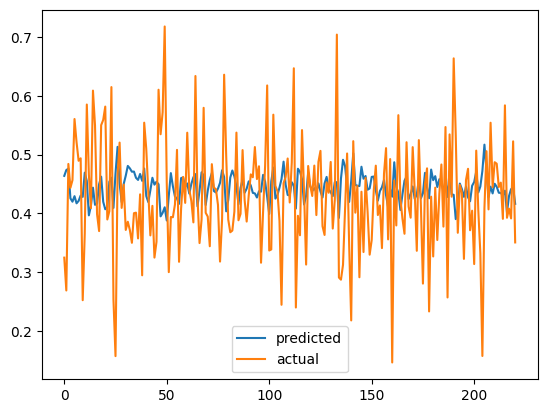

In [84]:
# plot out the predicted residual and actual residual
import matplotlib.pyplot as plt
plt.plot(predicted_residual, label='predicted')
plt.plot(y_test, label='actual')
plt.legend()

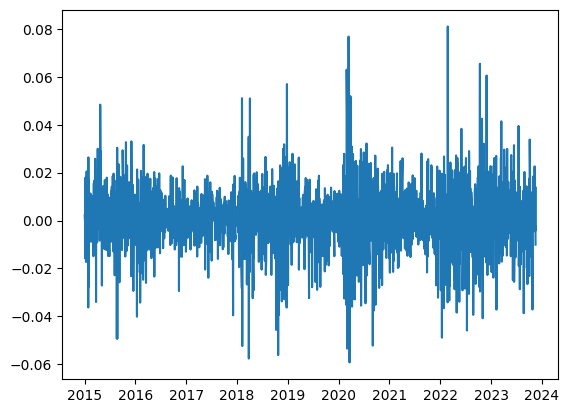

In [89]:
# plot out the data residual
plt.plot(df['Residual'])

In [85]:
# get MAE
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, predicted_residual)


0.07530370098466642

In [93]:
# test against mean residual
# get MAE

mean_absolute_error(y_test, np.full(y_test.shape,.43))

0.07206658484329545